# Nutrition Datas: Extracting trends from our customers

<div class="alert alert-block alert-info">
Now we are done with scrapping nutrition values, we want to build the actual nutrition profile: in order to do so, we first need to first extract the mass of each article, in order to assess the total sold mass.
</div>

In [94]:
from __future__ import print_function

%matplotlib inline
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from requests import get
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import MaxNLocator
import re
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle
import sys
sys.path.insert(1, './utilities/')
import weight_functions as wf 


In [95]:
product_df = pd.read_csv('../data/dunnhumby_data/product.csv')
transaction_data_df = pd.read_csv('../data/dunnhumby_data/transaction_data.csv')


## Limiting our dataset

In [96]:
food_related_arr = np.array(['NUTRITION','GROCERY','PASTRY','MEAT-PCKGD','SEAFOOD-PCKGD','PRODUCE','DELI','MEAT','SALAD BAR','GRO BAKERY','FROZEN GROCERY','SPIRITS','RESTAURANT'])
#products related to food only
food_product_df = product_df.loc[(product_df['DEPARTMENT'].isin(food_related_arr))]
food_product_df = food_product_df[~food_product_df.COMMODITY_DESC.isin(['PAPER TOWELS','BATH TISSUES','LAUNDRY DETERGENTS','FD WRAPS/BAGS/TRSH BG']) ]

#transaction dataset related to food only
food_transaction_data = transaction_data_df.merge(food_product_df,how = 'inner',on = 'PRODUCT_ID')
food_transaction_data['dunn_name'] = food_transaction_data['COMMODITY_DESC'] + " " + food_transaction_data['SUB_COMMODITY_DESC']
food_transaction_data = food_transaction_data.drop(columns = ['COMMODITY_DESC','SUB_COMMODITY_DESC'])[['household_key','BASKET_ID','PRODUCT_ID','QUANTITY','CURR_SIZE_OF_PRODUCT','dunn_name']]

<div class="alert alert-block alert-info">
We analyze the quantity according to 2 metrics: 
    
* (1) the number of times an item is bought 
* (2) the total sold mass of the item (kg)
    
Ideally one want to have an idea of which items are consumed the most in terms of mass, unfortunately, the mass section presents a lot of different units which are not easily parsable.
</div>

In [97]:
#as we can see, there are a lot of different units
units = food_transaction_data.CURR_SIZE_OF_PRODUCT.unique()
index = np.random.choice(units.shape[0], 30, replace=False)  
units[index]

array(['6 PK/15 OZ', '2PK/ 3 OZ', '25CT/63 OZ', '4.22 OZ', '9.25OZ',
       '20OZ BTLS', '18PK  12OZ', '6.77 OZ', '3.95 OZ', '8.9OZ',
       'P   .14 OZ', '16OZ', '12 FL OZ', '67.6  OZ', '24PC/5.5OZ',
       '3/4 X 18IN', '40 LB', '70 OZ', '9 IN 1 CT', '30.9 OZ', '3.3 LBS',
       '4PK/3CC', '4.5 OZ', '0.4 OZ', 'ALL  12 OZ', '2.05OZ', '15.21 OZ',
       '6P/11.2 OZ', '24.5 OZ', '22.80OZ'], dtype=object)

In [98]:
#(1) number of bought times
food_trans_data_count = food_transaction_data.groupby('dunn_name')\
                     .agg({'QUANTITY':'sum'})\
                     .sort_values(by = 'QUANTITY',ascending = False)

In [99]:
"""#(1) number of bought times
food_trans_data_count = food_transaction_data[['PRODUCT_ID','QUANTITY']].copy()
food_trans_data_count = food_trans_data_count.groupby('PRODUCT_ID')\
                     .sum()\
                     .join(product_df.set_index('PRODUCT_ID')[['COMMODITY_DESC','SUB_COMMODITY_DESC','CURR_SIZE_OF_PRODUCT']],how = 'left',on = 'PRODUCT_ID',lsuffix = '_l',rsuffix = '_r')\
                     .sort_values(by = 'QUANTITY',ascending = False)"""

"#(1) number of bought times\nfood_trans_data_count = food_transaction_data[['PRODUCT_ID','QUANTITY']].copy()\nfood_trans_data_count = food_trans_data_count.groupby('PRODUCT_ID')                     .sum()                     .join(product_df.set_index('PRODUCT_ID')[['COMMODITY_DESC','SUB_COMMODITY_DESC','CURR_SIZE_OF_PRODUCT']],how = 'left',on = 'PRODUCT_ID',lsuffix = '_l',rsuffix = '_r')                     .sort_values(by = 'QUANTITY',ascending = False)"

In [100]:
food_trans_data_count.shape[0]

2043

<div class="alert alert-block alert-info">
The idea consists thus to take the 4000 most bought items in terms of number (~70% of all sold counts) and extract their mass exclusively, since they present a less heterogeneous dataset for the mass units.
</div>

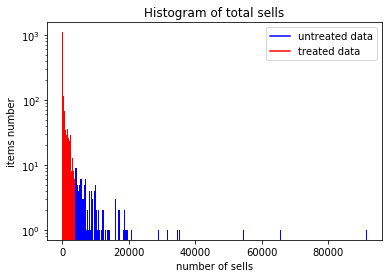

Ratio of total sells treated by treating the first 200 samples: 0.71


In [101]:
#we restrict ourself to treat the NUM first items
NUM = 200
N = food_trans_data_count.shape[0]
fig, ax = plt.subplots(1)
n_bins = 500
No, bins, patches = ax.hist(food_trans_data_count.QUANTITY,bins = n_bins)
ax.set_ylabel('items number')
ax.set_xlabel('number of sells')
ax.set_yscale('log')
ax.set_title('Histogram of total sells')
val = food_trans_data_count.QUANTITY.iloc[NUM]
val_bin = np.digitize(val,bins)

for i in range(0,val_bin):
    patches[i].set_facecolor('r')
for i in range(val_bin,n_bins):    
    patches[i].set_facecolor('b')
ax.plot([0,0],[0,0],'-b', label='untreated data')
ax.plot([0,0],[0,0],'-r', label='treated data')
ax.legend()
plt.show()
k = food_trans_data_count.iloc[:NUM].QUANTITY.values.sum()
t = food_trans_data_count.QUANTITY.values.sum()
ratio = k/t
print('Ratio of total sells treated by treating the first %i samples: %.2f' % (NUM,ratio) )

## Extracting the weight

In [102]:
from importlib import reload
reload(wf)

<module 'weight_functions' from './utilities/weight_functions.py'>

<div class="alert alert-block alert-info">
We now check that we indeed treat all the types of weights.
</div>

In [104]:
top4000 = food_transaction_data[food_transaction_data.dunn_name.isin(food_trans_data_count.index[:NUM])]
bad_units = top4000[~top4000.CURR_SIZE_OF_PRODUCT.str.contains('^.*(?:LB|GA|DZ|OZ|OUNCE|PK|CT|LITER|LT|LTR|ML|QT|PT|PINT|QUART).*$|^\s?$',regex=True)].CURR_SIZE_OF_PRODUCT.unique()
print('List of units not treated by the regex: {}'.format(bad_units))

List of units not treated by the regex: ['1GL' '3 PACK' '60 GM' 'LARGE' 'GL' '10 COUNT' '100 GRAM' '4 PACK'
 '45 GRAM' '1 GL' '5 GL']


In [106]:
"""#check if the weight is treatable for the top4000
top4000 = food_trans_data_count.iloc[:NUM].copy()
bad_units = top4000[~top4000.CURR_SIZE_OF_PRODUCT.str.contains('^.*(?:LB|GA|DZ|OZ|OUNCE|PK|CT|LITER|LT|LTR|ML|QT|PT|PINT|QUART).*$|^\s?$',regex=True)].CURR_SIZE_OF_PRODUCT.unique()
print('List of units not treated by the regex: {}'.format(bad_units))"""

"#check if the weight is treatable for the top4000\ntop4000 = food_trans_data_count.iloc[:NUM].copy()\nbad_units = top4000[~top4000.CURR_SIZE_OF_PRODUCT.str.contains('^.*(?:LB|GA|DZ|OZ|OUNCE|PK|CT|LITER|LT|LTR|ML|QT|PT|PINT|QUART).*$|^\\s?$',regex=True)].CURR_SIZE_OF_PRODUCT.unique()\nprint('List of units not treated by the regex: {}'.format(bad_units))"

In [107]:
def check_strange_unit (unit):
    return top4000[top4000.CURR_SIZE_OF_PRODUCT.str.contains(unit)].dunn_name.values
np.concatenate([check_strange_unit(unit) for unit in bad_units])

array(['FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUID MILK PRODUCTS FLUID MILK WHITE ONLY',
       'FLUI

In [108]:
top4000 = top4000[top4000.CURR_SIZE_OF_PRODUCT.str.contains('^.*(?:LB|GA|DZ|OZ|OUNCE|PK|CT|LITER|LT|LTR|ML|QT|PT|PINT|QUART).*$|^\s?$',regex=True)]

<div class="alert alert-block alert-info">
The followings are the units we encounter in the top 4000:
</div>

LB = pounds<br>
GA = gallons<br>
DZ = dozens (eggs)<br>
OZ,OUNCE = ounces<br>
PK = pack (0.33 liters)<br>
CT = counts ==> USER INPUT<br>
LITER LT = liters<br>
ML = milliliters<br>
QT = quantity ==> USER INPUT<br>
PT = pint (0.473176473 liters)<br>

### Weight finding


<div class="alert alert-block alert-info">
Once again, regexes were used (cf weight_functions.py) in order to parse the weight and convert it in kg. All the liquids were assumed to have water-like density. You can test the tool in the following cell.
</div>

In [109]:
UNITS = ['LB','GA','DZ','OZ','OUNCE','PK','CT','LITER','LT','ML','QT','PT']

test_weights_volumes = ['422 Lt','(600) 4OUNCE','5.323 OZ','there is 3 pint','2 CT']
def f(x):
    tested = test_weights_volumes[x]
    print('Tested expression: %s .Equivalent weight computed: %.2f kg' % (tested,wf.get_weight(tested)))
interact(f, x=widgets.IntSlider(min=0, max=len(test_weights_volumes) - 1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

In [110]:
top4000['SINGLE_WEIGHT']  = top4000.CURR_SIZE_OF_PRODUCT.apply(wf.get_weight).values

/home/ymentha/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<div class="alert alert-block alert-info">
The same method is used to extract the weight of the articles.
Unfortunately, the data whose metric is either CT,QT (quantity) or simply not present cannot easily be computed as this would require items specific weights. (a capsicon does not have the same weight as a pumpkin) 

We thus ask the user to estimate the weight of each item, thanks to the function start_create_single_weights.
</div>

In [112]:
ct_count = top4000[top4000.CURR_SIZE_OF_PRODUCT.str.contains('QT')].shape[0]
qt_count = top4000[top4000.CURR_SIZE_OF_PRODUCT.str.contains('QT')].shape[0]
space_count = top4000[top4000.CURR_SIZE_OF_PRODUCT == ' '].shape[0]
print('Number of non treated items: %i on %i items' % ((ct_count + qt_count + space_count),top4000.shape[0]))

Number of non treated items: 176087 on 1526859 items


In [113]:
single_weights_ct_df = pd.DataFrame.from_dict(wf.start_create_single_weights('CT',top4000),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})
single_weights_qt_df = pd.DataFrame.from_dict(wf.start_create_single_weights('QT',top4000),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})
single_weights_space_df = pd.DataFrame.from_dict(wf.start_create_single_weights('space',top4000),orient = 'index')\
                        .rename(columns = {0: 'SINGLE_WEIGHT'})

Successful read.
Successful read.
Successful read.


In [114]:
top4000 = top4000.join(single_weights_ct_df,how = 'left',rsuffix ='_r')
top4000.SINGLE_WEIGHT.fillna(top4000.SINGLE_WEIGHT_r,inplace = True)
top4000.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

top4000 = top4000.join(single_weights_qt_df,how = 'left',rsuffix ='_r')
top4000.SINGLE_WEIGHT.fillna(top4000.SINGLE_WEIGHT_r,inplace = True)
top4000.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

top4000 = top4000.join(single_weights_space_df,how = 'left',rsuffix ='_r')
top4000.SINGLE_WEIGHT.fillna(top4000.SINGLE_WEIGHT_r,inplace = True)
top4000.drop(columns = 'SINGLE_WEIGHT_r',inplace = True)

In [117]:
top4000['TOT_WEIGHT'] = top4000.SINGLE_WEIGHT * top4000.QUANTITY
top4000.sort_values(by = 'TOT_WEIGHT',ascending = False,inplace = True)

In [118]:
top4000.columns

Index(['household_key', 'BASKET_ID', 'PRODUCT_ID', 'QUANTITY',
       'CURR_SIZE_OF_PRODUCT', 'dunn_name', 'SINGLE_WEIGHT', 'TOT_WEIGHT'],
      dtype='object')

In [131]:
tot_weight_nut_df = top4000.reset_index()\
                     .groupby(['dunn_name']).agg({'TOT_WEIGHT':'sum'})\
                     .reset_index()\
                     .copy()
house_nut_df = top4000.reset_index()\
                      .groupby(['household_key','dunn_name'])\
                      .agg({'TOT_WEIGHT':'sum'})\
                      .reset_index()\
                      .copy()

## Adding the nutrition

<div class="alert alert-block alert-info">
 We can now finally try to extract the desired nutrition profile.
</div>

In [75]:
top4000.sort_values(by = 'TOT_WEIGHT',ascending = False, inplace = True)

In [76]:
with open(r"../results/dunnhumb_articles_nutriments.pickle", "rb") as input_file:
    all_nutrition = pickle.load(input_file)
with open(r"../results/nutriments_units.pickle", "rb") as input_file:
    nutriment_units_df = pickle.load(input_file)

In [77]:
top4000 = top4000.join(all_nutrition.set_index('dunn_name'),on = 'dunn_name',how = 'inner')\
                 .sort_values(by = 'TOT_WEIGHT',ascending = False)\
                 .reset_index()

In [132]:
house_nut_df = house_nut_df.join(all_nutrition.set_index('dunn_name'),on = 'dunn_name',how = 'inner')\
                 .sort_values(by = 'TOT_WEIGHT',ascending = False)\
                 .reset_index()

In [133]:
house_nut_df

,index,household_key,dunn_name,TOT_WEIGHT,dunn_ingredients,nut_name,nut_ingredients,cholesterol,energy,fatty acids total monounsaturated,...,fiber,protein,sodium,sugars,total lipid,vitamin a,vitamin b-12,vitamin b-6,vitamin e,vitamin k
0,153274,1609,TROPICAL FRUIT BANANAS,4173.273196,"[tropic, fruit, banana]","Fruit salad, Puerto Rican style (Mixture inclu...","[fruit, salad, puerto, rican, style, mixtur, i...",0.0,58.0,0.033,...,1.5,0.70,4.0,10.84,0.21,39.0,0.0,0.121,0.0,0.9
1,178301,1879,TROPICAL FRUIT BANANAS,3937.178560,"[tropic, fruit, banana]","Fruit salad, Puerto Rican style (Mixture inclu...","[fruit, salad, puerto, rican, style, mixtur, i...",0.0,58.0,0.033,...,1.5,0.70,4.0,10.84,0.21,39.0,0.0,0.121,0.0,0.9
2,164654,1740,TROPICAL FRUIT BANANAS,2703.408320,"[tropic, fruit, banana]","Fruit salad, Puerto Rican style (Mixture inclu...","[fruit, salad, puerto, rican, style, mixtur, i...",0.0,58.0,0.033,...,1.5,0.70,4.0,10.84,0.21,39.0,0.0,0.121,0.0,0.9
3,114298,1193,WATER - CARBONATED/FLVRD DRINK NON-CRBNTD DRNK...,2368.497732,"[water, carbon, flavor, drink, non, crbntd, dr...","Fruit juice and water drink, with high vitamin...","[fruit, juic, water, drink, high, vitamin, cal...",0.0,31.0,0.002,...,0.0,0.00,11.0,6.12,0.00,0.0,0.0,0.022,0.0,0.2
4,105415,1098,TROPICAL FRUIT BANANAS,2267.960000,"[tropic, fruit, banana]","Fruit salad, Puerto Rican style (Mixture inclu...","[fruit, salad, puerto, rican, style, mixtur, i...",0.0,58.0,0.033,...,1.5,0.70,4.0,10.84,0.21,39.0,0.0,0.121,0.0,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228722,219549,2300,FRZN NOVELTIES/WTR ICE WATER ICE,0.000000,"[novelti, wtr, ice, water]",Water chestnut,"[water, chestnut]",0.0,78.0,0.002,...,3.9,1.38,12.0,3.84,0.09,0.0,0.0,0.248,0.0,0.3
228723,219686,2301,FRZN NOVELTIES/WTR ICE WATER ICE,0.000000,"[novelti, wtr, ice, water]",Water chestnut,"[water, chestnut]",0.0,78.0,0.002,...,3.9,1.38,12.0,3.84,0.09,0.0,0.0,0.248,0.0,0.3
228724,220577,2312,FRZN NOVELTIES/WTR ICE WATER ICE,0.000000,"[novelti, wtr, ice, water]",Water chestnut,"[water, chestnut]",0.0,78.0,0.002,...,3.9,1.38,12.0,3.84,0.09,0.0,0.0,0.248,0.0,0.3
228725,220908,2317,FRZN NOVELTIES/WTR ICE WATER ICE,0.000000,"[novelti, wtr, ice, water]",Water chestnut,"[water, chestnut]",0.0,78.0,0.002,...,3.9,1.38,12.0,3.84,0.09,0.0,0.0,0.248,0.0,0.3


In [84]:
nutriments = top4000.drop(top4000.columns[np.arange(6)],axis = 1).columns.values

In [86]:
def g(x):
    nutriment = nutriments[x]
    fig,ax = plt.subplots(1)
    #top4000[top4000.TOT_WEIGHT != 0].reset_index().head(4000).plot.bar(y = nutriment,ax = ax)
    temp = top4000[top4000.TOT_WEIGHT != 0].reset_index().head(300)
    sns.barplot(x = temp.index,y = temp[nutriment])
    unit = nutriment_units_df[nutriment_units_df['name'] == nutriment].unit_name.values[0]
    ax.set_title(nutriment)
    ax.set_ylabel('%s %s per 100 grams' % (nutriment,unit))
    ax.set_xlabel('items (sorted by most bought mass)')
    """empty_string_labels = ['']*len(ax.get_xticklabels())
    ax.set_xticklabels(empty_string_labels)"""
interact(g, x=widgets.IntSlider(min=0, max=len(nutriments) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=14), Output()), _dom_classes=('widget-interact',…

In [87]:
for nut in nutriments:
    top4000['tot_' + nut] = top4000.TOT_WEIGHT * top4000[nut]

In [ ]:
import tabulate

In [89]:
def g(x):
    nutriment = nutriments[x]
    temp = top4000.sort_values(by = 'tot_' + nutriment,ascending = False)[['TOT_WEIGHT','dunn_name','nut_name','tot_' + nutriment]].head(5)
    print(nutriment.upper() + ' TOP NUTRIMENTS')
    print(temp)
interact(g, x=widgets.IntSlider(min=0, max=len(nutriments) - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=14), Output()), _dom_classes=('widget-interact',…